In [26]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
path_to_file = 'C:/Users/olran/Desktop/test4.xlsx'

In [28]:
xl = pd.ExcelFile(path_to_file)
df_test4 = xl.parse('Аркуш1')

In [29]:
display( df_test4.dtypes, df_test4.shape)

rd             datetime64[ns]
customer_id             int64
TD                     object
revenue_usd            object
dtype: object

(4287, 4)

In [30]:
df_test4

,rd,customer_id,TD,revenue_usd
0,2017-11-24,981511946,2018-05-22 00:00:00,4.621145
1,2017-11-24,981511946,2019-06-08 00:00:00,4.622467
2,2017-11-24,981511946,2018-05-14 00:00:00,0
3,2017-11-24,981511949,(null),(null)
4,2017-11-24,981511950,(null),(null)
...,...,...,...,...
4282,2019-05-11,981516228,(null),(null)
4283,2019-05-11,981516229,(null),(null)
4284,2019-05-11,981516230,(null),(null)
4285,2019-05-11,981516231,(null),(null)


In [31]:
df_test4['TD'].replace('null', pd.NA, inplace=True)
df_test4['TD'] = pd.to_datetime(df_test4['TD'], errors='coerce')

df_test4['revenue_usd'].replace('null', pd.NA, inplace=True)
df_test4['revenue_usd'] = pd.to_numeric(df_test4['revenue_usd'], errors='coerce')

In [32]:
display( df_test4.dtypes, df_test4.shape)

rd             datetime64[ns]
customer_id             int64
TD             datetime64[ns]
revenue_usd           float64
dtype: object

(4287, 4)

In [33]:
df_filtered = df_test4.dropna(subset=['TD', 'revenue_usd'])
#df_filtered = df_filtered.loc[df_filtered['revenue_usd'] != 0]
#Варто пофільтрувати неактуальні дані, для того щоб не виникало помилок, в даному випадку нецікавими є користувачі, які не здійснили жодної покупки з дати реєстрації

In [34]:
df_filtered

,rd,customer_id,TD,revenue_usd
0,2017-11-24,981511946,2018-05-22,4.621145
1,2017-11-24,981511946,2019-06-08,4.622467
2,2017-11-24,981511946,2018-05-14,0.000000
15,2017-11-28,981511961,2018-01-29,4.621145
20,2017-11-30,981511966,2018-07-07,0.000000
...,...,...,...,...
4245,2019-05-06,981516190,2019-05-06,0.000000
4246,2019-05-06,981516190,2019-05-15,4.622467
4250,2019-05-06,981516196,2019-05-06,0.000000
4268,2019-05-09,981516214,2019-05-09,0.000000


In [40]:
start_date = df_filtered['rd']
end_date = start_date + pd.DateOffset(months=6)

df_filtered = df_filtered[(df_filtered['TD'] >= start_date) & (df_filtered['TD'] < end_date)]

# Групування по користувачам та підрахунок загального доходу за 6 місяців
ltv_6_months_per_user = df_filtered.groupby('customer_id')['revenue_usd'].sum().reset_index()
ltv_6_months_per_user = ltv_6_months_per_user.rename(columns={'revenue_usd': 'LTV'})
ltv_6_months_per_user


,customer_id,LTV
0,981511946,4.621145
1,981511961,4.621145
2,981512008,8.308370
3,981512042,0.000000
4,981512077,2.149780
...,...,...
516,981516182,18.489868
517,981516190,9.244934
518,981516196,0.000000
519,981516214,0.000000


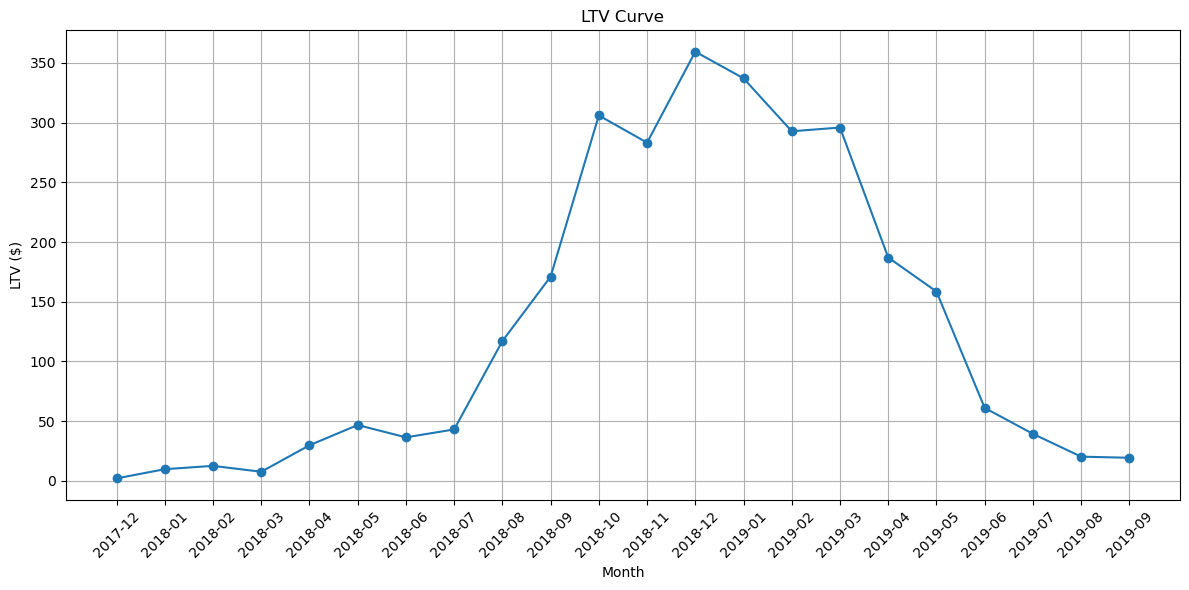

In [42]:
df_filtered['month'] = df_filtered['TD'].dt.to_period('M')

start_date = df_filtered['rd'].min()
end_date = df_filtered['TD'].max()
periods = pd.period_range(start=start_date.to_period('M').start_time, end=end_date.to_period('M').end_time, freq='M')

ltv_data = []

for period in periods:

    period_start = period.start_time
    period_end = period.end_time
    
    period_data = df_filtered[(df_filtered['TD'] >= period_start) & (df_filtered['TD'] <= period_end)]
    
    # Розрахунок LTV для кожного користувача
    ltv_per_user = period_data.groupby('customer_id')['revenue_usd'].sum().reset_index()
    ltv_per_user['month'] = period
    
    ltv_data.append(ltv_per_user)

ltv_df = pd.concat(ltv_data)
ltv_df = ltv_df.groupby('month')['revenue_usd'].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(ltv_df['month'].astype(str), ltv_df['revenue_usd'], marker='o', linestyle='-')
plt.title('LTV Curve')
plt.xlabel('Month')
plt.ylabel('LTV ($)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()